# Tel-Aviv rezoning feasibility evaluation

## Research objective
Tel-Aviv City had recently (January 2018) approved a new zoning plan for one of its city center precincts, **precinct no.3**, or **“The old North”** neighborhood, and is about to approve a similar rezoning for the neighbor **precinct no.4 (“The new North)**. The purpose of this research is to evaluate these two plans in terms of their **feasibility** and the future **floor/area ratio (FAR)** they would have formulate if fully implemented. This research attempts to assess whether the rezoning of these two precincts, although allowing more floor area to be built, **is feasible enough for developers to renew the buildings**.

# Imports

In [1]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
import json
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


# Data aquiring

Data were aquired from [Tel-Aviv GIS](https://gisn.tel-aviv.gov.il/); 
- **Zoning plan no. 3616a** (Precinct 03) was selected
- Data were downloaded seperately for **_outside the White City Zone_** and **_inside the White City Zone_** (North and South to Arlozorov street). 
- _About **60%** of precinct 3 is **within the White City Zone.**_
- Within the plan's boundaries, the following layers were chosen and downloaded as _shapefiles_:
    - **Parcels** 
    - **Buildings** 
    - **Addresses**
    - **Historic Preservation**
    
    
- For each df, **commercial streets** were distinguished due to their different rezoning instructions.
- For each df, **historic preservation designated buildings** were excluded from the analysis (as these have different zoning).

# TLV shapefiles
## Precinct no.3 boundary

In [516]:
PCT3 = gpd.GeoDataFrame.from_file('data/boundary3/Quarters.shp')
PCT3.head()

,oidrova,krova,dateimport,ShapeArea,geometry
0,3.0,3.0,01/12/2015 02:28:14,3.380430e+06,"POLYGON ((34.78366001782263 32.09671028569601,..."


## the "White City" Zone 
A world heritage site declared by UNESCO at 2003 


In [517]:
# white city zone
whitecity = gpd.GeoDataFrame.from_file('data/all/whitecity/White City Zone.shp')
#whitecity = whitecity.drop(["oidktovet",'krechov','trechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'tktovetmel', 'dateimport', 'geometry'], axis = 1)
#whitecity.columns = [['idAddress', 'oldidAddress', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

whitecity.head()
# historic preservation

,oidezor,shemezor,tezor,kezor,dateimport,geometry
0,1.0,BUFFER,אזור חייץ הכרזה,4.0,17/01/2013 02:12:19,"POLYGON ((34.77010483312776 32.08548408809591,..."
1,2.0,ZONE A,אזור ההכרזה,1.0,17/01/2013 02:12:19,"POLYGON ((34.77053337341343 32.08536861271146,..."
2,3.0,BUFFER,אזור חייץ הכרזה,4.0,17/01/2013 02:12:19,"POLYGON ((34.77010483312776 32.08548408809591,..."
3,4.0,ZONE A,אזור ההכרזה,1.0,17/01/2013 02:12:19,"POLYGON ((34.77053337341343 32.08536861271146,..."
4,5.0,BUFFER,אזור חייץ הכרזה,4.0,17/01/2013 02:12:19,"POLYGON ((34.77063964786722 32.07718216118067,..."


## Parcels precinct 3

In [518]:
# All precinct; in order to plot background for the city
parcelsshp = gpd.GeoDataFrame.from_file('data/all/parcelsshp/Parcels.shp')
parcelsshp = parcelsshp.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshp.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

parcelsshp.shape

(4560, 5)

### >> Precinct no.3 contains 4560 parcels.

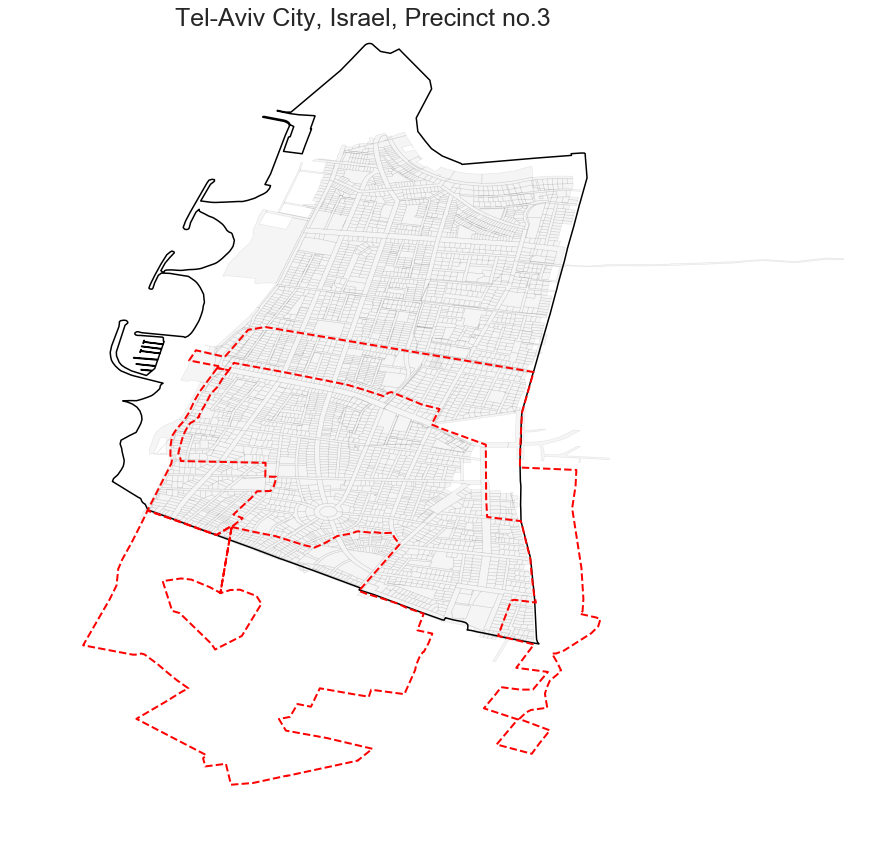

In [519]:
fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='grey', edgecolor='k',linewidth=.6, alpha=0.08)
PCT3.plot(ax=ax, color='none', edgecolor='k', linewidth=1.5);
whitecity[whitecity['oidezor'] == 1.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');
whitecity[whitecity['oidezor'] == 3.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');
whitecity[whitecity['oidezor'] == 5.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');

plt.title('Tel-Aviv City, Israel, Precinct no.3', size=25, y=.97, x=0.38)
tmp = ax.axis('off')

### Fig.1 Precinct no.3, Tel-Aviv City, Israel
The **western boundary** is the **Mediterian Sea**; The **northern boundary** is **HaYarkon river**; The **Eastern boundary** is **Precinct no.4** (seperated by _Eben-Gvirol street_) and the **Southern boundary** is **Precinct no.5** (seperated by _Bugrashov street_).<br/>
The red dashed lines are the **"White City" Zone boundaries**. Zonings do not differ between the different areas of the White City. 

In [520]:
# Inside White City Zone
parcelsshpIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Parcels.shp')
parcelsshpIN = parcelsshpIN.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshpIN.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

# creating BBL column (Block+Parcel)
parcelsshpIN['BBL'] = list(zip(parcelsshpIN.Block,parcelsshpIN.Parcel))
parcelsshpIN = parcelsshpIN.drop(['Block', 'Parcel'], axis=1)

parcelsshpIN.head()

,idParcel,ParcelArea,geometry,BBL
0,2079.0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)"
1,2081.0,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)"
2,2310.0,8.0,"POLYGON ((34.77327859883683 32.0863077792844, ...","(6902.0, 182.0)"
3,2311.0,12.0,"POLYGON ((34.77328772327471 32.08625947460223,...","(6902.0, 185.0)"
4,3208.0,281.0,"POLYGON ((34.77303315814694 32.08714497353659,...","(6902.0, 59.0)"


In [521]:
parcelsshpIN.shape

(2769, 4)

In [522]:
# Outside White City Zone
parcelsshpOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Parcels.shp')
parcelsshpOUT = parcelsshpOUT.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshpOUT.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

# creating BBL column (Block+Parcel)
parcelsshpOUT['BBL'] = list(zip(parcelsshpOUT.Block,parcelsshpOUT.Parcel))
parcelsshpOUT = parcelsshpOUT.drop(['Block', 'Parcel'], axis=1)

parcelsshpOUT.head()

,idParcel,ParcelArea,geometry,BBL
0,467.0,282.0,"POLYGON ((34.77856318885686 32.09408597755429,...","(6959.0, 32.0)"
1,469.0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)"
2,471.0,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)"
3,480.0,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)"
4,523.0,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)"


In [523]:
parcelsshpOUT.shape

(1911, 4)

### >> About 60% of precinct no.3 parcels are within the _"White City" Zone_ (South to Arlozorov street)

## Buildings precinct 3

In [524]:
# Inside White City Zone

buildingsshpIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Buildings.shp')
buildingsshpIN = buildingsshpIN.drop(["shemmivne",'tamudim','dateimport', 'ShapeLengt', 'geometry'], axis = 1)
buildingsshpIN.columns = [['idConst', 'idBuilding', 'BuildingType', 'Floors', 'footprint', 'idBuildingOriginal', 'height']]
buildingsshpIN.head()

,idConst,idBuilding,BuildingType,Floors,footprint,idBuildingOriginal,height
0,21336.0,22826.0,מבנה בבנייה,4.0,351.225764,66222.0,16.0
1,21337.0,22827.0,מבנה רגיל,4.0,202.071150,66230.0,17.0
2,21338.0,22828.0,מבנה רגיל,4.0,392.806769,69687.0,18.0
3,21339.0,22829.0,מבנה רגיל,4.0,299.650683,65772.0,17.0
4,21340.0,22830.0,מבנה רגיל,3.0,310.687994,65783.0,18.0


In [525]:
buildingsshpIN.shape

(2563, 7)

In [526]:
# Outside White City Zone

buildingsshpOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Buildings.shp')
buildingsshpOUT = buildingsshpOUT.drop(["shemmivne",'tamudim','dateimport', 'ShapeLengt', 'geometry'], axis = 1)
buildingsshpOUT.columns = [['idConst', 'idBuilding', 'BuildingType', 'Floors', 'footprint', 'idBuildingOriginal', 'height']]
buildingsshpOUT.head()

,idConst,idBuilding,BuildingType,Floors,footprint,idBuildingOriginal,height
0,20915.0,22392.0,מבנה רגיל,4.0,123.433980,74178.0,15.0
1,20916.0,22394.0,מבנה רגיל,3.0,144.257155,79229.0,19.0
2,20917.0,22395.0,מבנה רגיל,1.0,69.271012,56945.0,22.0
3,20918.0,22396.0,מבנה רגיל,6.0,220.711618,55271.0,29.0
4,20919.0,22397.0,מבנה רגיל,6.0,267.161697,74812.0,23.0


In [527]:
buildingsshpOUT.shape

(1650, 7)

## Addresses precinct 3

In [528]:
# Inside White City Zone

AddressesIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Addresses.shp')
AddressesIN = AddressesIN.drop(["oidktovet",'krechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'dateimport', 'geometry'], axis = 1)
AddressesIN.columns = [['idAddress', 'oldidAddress', 'streetName', 'Address', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

# creating BBL column (Block+Parcel)
AddressesIN['BBL'] = list(zip(AddressesIN.Block,AddressesIN.Parcel))
AddressesIN = AddressesIN.drop(['Block', 'Parcel'], axis=1)

AddressesIN.head()

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75906.0,75906.0,הפרדס,הפרדס 9,179454.431532,665746.201281,34.780725,32.084308,"(6215.0, 294.0)"
1,74570.0,74570.0,בן גוריון,בן גוריון 59,178937.908125,665746.201281,34.775254,32.084291,"(6954.0, 98.0)"
2,69885.0,69885.0,רופין,רופין 45,178556.837843,665746.154375,34.771218,32.084277,"(6968.0, 68.0)"
3,73452.0,73452.0,שלמה המלך,שלמה המלך 93,179247.462858,665746.076311,34.778533,32.084300,"(6215.0, 202.0)"
4,76166.0,76166.0,באר טוביה,באר טוביה 24,179015.080046,665744.451250,34.776071,32.084278,"(6954.0, 89.0)"


In [529]:
AddressesIN.shape

(2863, 9)

In [530]:
# Outside White City Zone

AddressesOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Addresses.shp')
AddressesOUT = AddressesOUT.drop(["oidktovet",'krechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'dateimport', 'geometry'], axis = 1)
AddressesOUT.columns = [['idAddress', 'oldidAddress', 'streetName', 'Address', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

# creating BBL column (Block+Parcel)
AddressesOUT['BBL'] = list(zip(AddressesOUT.Block,AddressesOUT.Parcel))
AddressesOUT = AddressesOUT.drop(['Block', 'Parcel'], axis=1)

AddressesOUT.head()

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75400.0,75400.0,מיכה,מיכה 15,178988.400358,666805.232500,34.775744,32.093842,"(6961.0, 67.0)"
1,73105.0,73105.0,דיזנגוף,דיזנגוף 294,179091.845656,666804.826250,34.776840,32.093842,"(6959.0, 77.0)"
2,74069.0,74069.0,סוקולוב,סוקולוב 97,179242.033110,666803.560640,34.778431,32.093836,"(6959.0, 40.0)"
3,74897.0,74897.0,יחזקאל,יחזקאל 17,179178.251875,666803.263765,34.777756,32.093831,"(6959.0, 125.0)"
4,74710.0,74710.0,ישעיהו,ישעיהו 22,179330.033125,666801.732500,34.779363,32.093823,"(6957.0, 9.0)"


In [531]:
AddressesOUT.shape

(1878, 9)

## Historic Preservation designated buildings precinct 3

In [532]:
# Inside White City Zone

HistoricIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Historical Buildings.shp')
HistoricIN = HistoricIN.drop(["OBJECTID",'shemmivne', 'swhistory', 'hagbalot','atraawarn', 'trhatraot', 'trmivnim'], axis = 1)

HistoricIN.head()

,thatraa,sttaba,ktovot,geometry
0,שימור - בינלאומי,2650ב,הירקון 118,"POLYGON ((34.76846874076895 32.08115666808349,..."
1,שימור - בינלאומי,2650ב,"בן יהודה 96 ,גורדון יהודה ליב 24","POLYGON ((34.77118473380646 32.08199703366387,..."
2,שימור - בינלאומי,2650ב,"הכרם 7 ,רופין 27","POLYGON ((34.77060031643551 32.08323174401378,..."
3,שימור - בינלאומי,2650ב,"בן גוריון 45 ,דיזנגוף 166","POLYGON ((34.77448150184389 32.08451973806656,..."
4,שימור - בינלאומי,2650ב,"בן גוריון 37 ,גרץ 1","POLYGON ((34.77351286195784 32.08477260898684,..."


In [533]:
HistoricIN.shape

(436, 4)

In [534]:
# Outside White City Zone

HistoricOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Historical Buildings.shp')
HistoricOUT = HistoricOUT.drop(["OBJECTID",'shemmivne', 'swhistory', 'hagbalot','atraawarn', 'trhatraot', 'trmivnim'], axis = 1)

HistoricOUT.head()

,thatraa,sttaba,ktovot,geometry
0,שימור - בינלאומי,2650ב,"נורדאו 23 ,מיכה 2 ,מיכה 2א","POLYGON ((34.77573011759602 32.09261045347858,..."
1,שימור - בינלאומי,2650ב,נורדאו 15,"POLYGON ((34.77435722680622 32.0927583013431, ..."
2,שימור - בינלאומי,2650ב,נורדאו 9,"POLYGON ((34.77372277584232 32.09281543839031,..."
3,שימור - בינלאומי,2650ב,בן יהודה 201,"POLYGON ((34.77462431087153 32.09301221255826,..."
4,שימור - בינלאומי,2650ב,נחום הנביא 6,"POLYGON ((34.77429674374923 32.09310789846018,..."


In [535]:
HistoricOUT.shape

(45, 4)

### >> Most of the precinct's historic preservation designated buildings are within the "White City" Zone

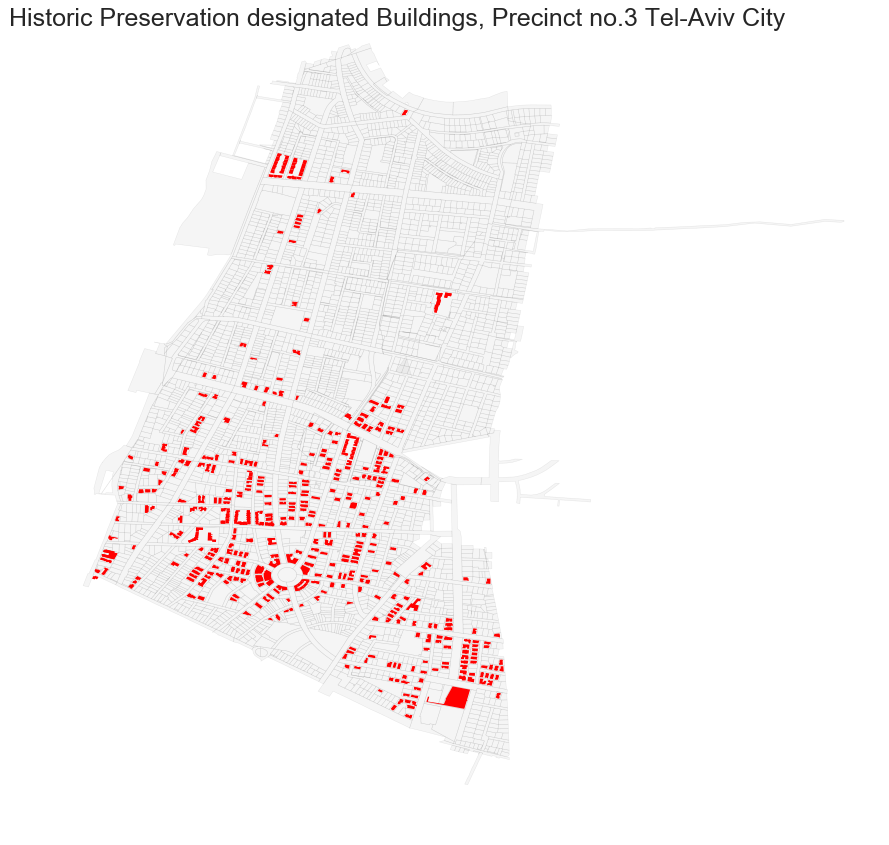

In [536]:
fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='grey', edgecolor='k',linewidth=.5, alpha=0.08)
HistoricOUT.plot(ax=ax, color='red', edgecolor=None);
HistoricIN.plot(ax=ax, color='red', edgecolor=None);
#whitecity[whitecity['oidezor'] == 1.0].plot(ax=ax, color='none', edgecolor='Indianred',linestyle='dashed', linewidth=2, label='White City Zone');
#whitecity[whitecity['oidezor'] == 3.0].plot(ax=ax, color='none', edgecolor='Indianred',linestyle='dashed', linewidth=2, label='White City Zone');
#whitecity[whitecity['oidezor'] == 5.0].plot(ax=ax, color='none', edgecolor='Indianred',linestyle='dashed', linewidth=2, label='White City Zone');

plt.title('Historic Preservation designated Buildings, Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

### Fig.2 Historic Preservation designated Buildings, Precinct no.3 Tel-Aviv City
These buildings have different zoning and thus were excluded from this analysis.

## Joining Addresses + Historic preservation in order to remove historic buildings

In [537]:
AddressesIN = AddressesIN.merge(HistoricIN, left_on = 'Address', right_on = 'ktovot', how='left').fillna(0)
AddressesIN = AddressesIN[AddressesIN['thatraa'] == 0]
AddressesIN = AddressesIN.drop(['thatraa', 'sttaba', 'ktovot','geometry'], axis=1)
AddressesIN.shape

(2600, 9)

In [538]:
AddressesIN.head(3)

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75906.0,75906.0,הפרדס,הפרדס 9,179454.431532,665746.201281,34.780725,32.084308,"(6215.0, 294.0)"
1,74570.0,74570.0,בן גוריון,בן גוריון 59,178937.908125,665746.201281,34.775254,32.084291,"(6954.0, 98.0)"
2,69885.0,69885.0,רופין,רופין 45,178556.837843,665746.154375,34.771218,32.084277,"(6968.0, 68.0)"


In [539]:
AddressesOUT = AddressesOUT.merge(HistoricOUT, left_on = 'Address', right_on = 'ktovot', how='left').fillna(0)
AddressesOUT = AddressesOUT[AddressesOUT['thatraa'] == 0]
AddressesOUT = AddressesOUT.drop(['thatraa', 'sttaba', 'ktovot','geometry'], axis=1)
AddressesOUT.shape

(1849, 9)

In [540]:
AddressesOUT.head(3)

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75400.0,75400.0,מיכה,מיכה 15,178988.400358,666805.23250,34.775744,32.093842,"(6961.0, 67.0)"
1,73105.0,73105.0,דיזנגוף,דיזנגוף 294,179091.845656,666804.82625,34.776840,32.093842,"(6959.0, 77.0)"
2,74069.0,74069.0,סוקולוב,סוקולוב 97,179242.033110,666803.56064,34.778431,32.093836,"(6959.0, 40.0)"


# Joining shp to have Buildings + Parcels data for each observation
### White City Zone

In [541]:
PCT3shpIN = parcelsshpIN.merge(AddressesIN, on = 'BBL')
PCT3shpIN.head()

,idParcel,ParcelArea,geometry,BBL,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat
0,2079.0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",76317.0,76317.0,ברנשטיין אדוארד,ברנשטיין אדוארד 26,178681.048750,666071.357485,34.772520,32.087214
1,2081.0,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)",73537.0,73537.0,ארלוזורוב,ארלוזורוב 16,178763.595656,666063.263750,34.773394,32.087144
2,2081.0,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)",65865.0,65865.0,בן יהודה,בן יהודה 172,178753.814406,666062.545031,34.773291,32.087137
3,3208.0,281.0,"POLYGON ((34.77303315814694 32.08714497353659,...","(6902.0, 59.0)",65834.0,65834.0,בן יהודה,בן יהודה 141,178721.853437,666058.482546,34.772952,32.087099
4,3209.0,518.0,"POLYGON ((34.77120851853805 32.08690002717208,...","(6966.0, 20.0)",66281.0,66281.0,הירקון,הירקון 186,178553.064406,666058.013765,34.771164,32.087089


In [542]:
PCT3shpIN.shape

(2600, 12)

In [543]:
PCT3shpIN = PCT3shpIN.merge(buildingsshpIN, right_on = 'idBuildingOriginal', left_on = 'idAddress')
PCT3shpIN = PCT3shpIN.drop(['idConst', 'idBuilding','idAddress', 'Address', 'oldidAddress', 'idParcel', 'idBuildingOriginal'], axis = 1)

PCT3shpIN.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,BuildingType,Floors,footprint,height
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",ברנשטיין אדוארד,178681.048750,666071.357485,34.772520,32.087214,מבנה רגיל,3.0,154.417758,17.0
1,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)",בן יהודה,178753.814406,666062.545031,34.773291,32.087137,מבנה רגיל,5.0,144.052006,22.0
2,281.0,"POLYGON ((34.77303315814694 32.08714497353659,...","(6902.0, 59.0)",בן יהודה,178721.853437,666058.482546,34.772952,32.087099,מבנה רגיל,5.0,158.177808,22.0
3,518.0,"POLYGON ((34.77120851853805 32.08690002717208,...","(6966.0, 20.0)",הירקון,178553.064406,666058.013765,34.771164,32.087089,מבנה רגיל,4.0,247.139010,18.0
4,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",השופטים,179488.994062,664838.560656,34.781129,32.076125,מבנה רגיל,4.0,252.530801,16.0


In [544]:
PCT3shpIN.shape

(1642, 12)

In [545]:
type(PCT3shpIN)

geopandas.geodataframe.GeoDataFrame

### outside White City Zone

In [546]:
PCT3shpOUT = parcelsshpOUT.merge(AddressesOUT, on = 'BBL')
PCT3shpOUT.head()

,idParcel,ParcelArea,geometry,BBL,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat
0,467.0,282.0,"POLYGON ((34.77856318885686 32.09408597755429,...","(6959.0, 32.0)",74071.0,74071.0,סוקולוב,סוקולוב 101,179249.556608,666838.013735,34.778509,32.094147
1,469.0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",74701.0,74701.0,ישעיהו,ישעיהו 12,179300.251875,666835.216860,34.779047,32.094123
2,471.0,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",75404.0,75404.0,מיכה,מיכה 19,178975.822157,666836.638796,34.775610,32.094125
3,480.0,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",74955.0,74955.0,מלאכי,מלאכי 14,179141.806578,666693.248156,34.777374,32.092838
4,523.0,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)",74760.0,74760.0,יוחנן הורקנוס,יוחנן הורקנוס 11,179451.892531,666819.029375,34.780654,32.093983


In [547]:
PCT3shpOUT.shape

(1849, 12)

In [548]:
PCT3shpOUT = PCT3shpOUT.merge(buildingsshpOUT, right_on = 'idBuildingOriginal', left_on = 'idAddress')
PCT3shpOUT = PCT3shpOUT.drop(['idConst', 'idBuilding','idAddress', 'Address','oldidAddress', 'idParcel', 'idBuildingOriginal'], axis = 1)

PCT3shpOUT.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,BuildingType,Floors,footprint,height
0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",ישעיהו,179300.251875,666835.216860,34.779047,32.094123,מבנה רגיל,4.0,117.242392,13.0
1,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",מיכה,178975.822157,666836.638796,34.775610,32.094125,מבנה רגיל,4.0,208.665958,18.0
2,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",מלאכי,179141.806578,666693.248156,34.777374,32.092838,מבנה רגיל,4.0,155.031697,17.0
3,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)",יוחנן הורקנוס,179451.892531,666819.029375,34.780654,32.093983,מבנה רגיל,3.0,303.026016,13.0
4,533.0,"POLYGON ((34.7804767984501 32.09392660250479, ...","(6958.0, 123.0)",יוחנן הורקנוס,179434.376860,666817.998110,34.780468,32.093973,מבנה רגיל,4.0,276.398086,22.0


In [549]:
PCT3shpOUT.shape

(1176, 12)

In [550]:
type(PCT3shpOUT)

geopandas.geodataframe.GeoDataFrame

# Data cleaning and munging
### White City Zone

In [551]:
# dropping buildings that are not 2-4 floors, assuming the rezoning is not valid to them
PCT3shpIN = (PCT3shpIN[PCT3shpIN['Floors'] <= 4.0])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['Floors'] >= 3.0])

# dropping non-residential buildings
PCT3shpIN = (PCT3shpIN[PCT3shpIN['BuildingType'] == 'מבנה רגיל']).reset_index()
PCT3shpIN = PCT3shpIN.drop(['index', 'BuildingType'], axis=1)

# dropping area > 1250 m2
PCT3shpIN = (PCT3shpIN[PCT3shpIN['ParcelArea'] <= 1250])


# Calculating Floor Area (Floors * ShapeArea)
PCT3shpIN['FloorArea'] = PCT3shpIN['Floors'] * PCT3shpIN['footprint']
# Calculating Floor-Area Ratio (FAR) (FA / ParcelArea)
PCT3shpIN['FAR'] = PCT3shpIN['FloorArea'] / PCT3shpIN['ParcelArea']
#PCT3shpIN = (PCT3shpIN[PCT3shpIN['FAR'] <= 3])

#White city zone == 1
PCT3shpIN['WhiteCity'] = 1

PCT3shpIN.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",ברנשטיין אדוארד,178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,1
1,518.0,"POLYGON ((34.77120851853805 32.08690002717208,...","(6966.0, 20.0)",הירקון,178553.064406,666058.013765,34.771164,32.087089,4.0,247.139010,18.0,988.556038,1.908409,1
2,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",השופטים,179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,1
3,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",פינסקר,178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,1
4,360.0,"POLYGON ((34.77120676544948 32.07850701386839,...","(6906.0, 81.0)",שלום עליכם,178535.861235,665120.513781,34.771022,32.078635,4.0,150.359237,19.0,601.436948,1.670658,1


In [552]:
PCT3shpIN.shape

(1310, 14)

### outside White City Zone

In [553]:
# dropping buildings that are not 2-4 floors, assuming the rezoning is not valid to them
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['Floors'] <= 4.0])
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['Floors'] >= 3.0])

# dropping non-residential buildings
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['BuildingType'] == 'מבנה רגיל']).reset_index()
PCT3shpOUT = PCT3shpOUT.drop(['index', 'BuildingType'], axis=1)

# dropping area > 1250 m2
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['ParcelArea'] <= 1250])


# Calculating Floor Area (Floors * ShapeArea)
PCT3shpOUT['FloorArea'] = PCT3shpOUT['Floors'] * PCT3shpOUT['footprint']
# Calculating Floor-Area Ratio (FAR) (FA / ParcelArea)
PCT3shpOUT['FAR'] = PCT3shpOUT['FloorArea'] / PCT3shpOUT['ParcelArea']
#PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['FAR'] <= 3])

#White city zone == 0
PCT3shpOUT['WhiteCity'] = 0

PCT3shpOUT.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity
0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",ישעיהו,179300.251875,666835.216860,34.779047,32.094123,4.0,117.242392,13.0,468.969568,1.705344,0
1,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",מיכה,178975.822157,666836.638796,34.775610,32.094125,4.0,208.665958,18.0,834.663832,2.001592,0
2,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",מלאכי,179141.806578,666693.248156,34.777374,32.092838,4.0,155.031697,17.0,620.126790,1.908082,0
3,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)",יוחנן הורקנוס,179451.892531,666819.029375,34.780654,32.093983,3.0,303.026016,13.0,909.078048,1.643902,0
4,533.0,"POLYGON ((34.7804767984501 32.09392660250479, ...","(6958.0, 123.0)",יוחנן הורקנוס,179434.376860,666817.998110,34.780468,32.093973,4.0,276.398086,22.0,1105.592344,2.074282,0


In [554]:
PCT3shpOUT.shape

(862, 14)

In [555]:
PCT3shp = [PCT3shpIN, PCT3shpOUT]
PCT3shp = pd.concat(PCT3shp)
PCT3shp.shape

(2172, 14)

In [556]:
type(PCT3shp)

geopandas.geodataframe.GeoDataFrame

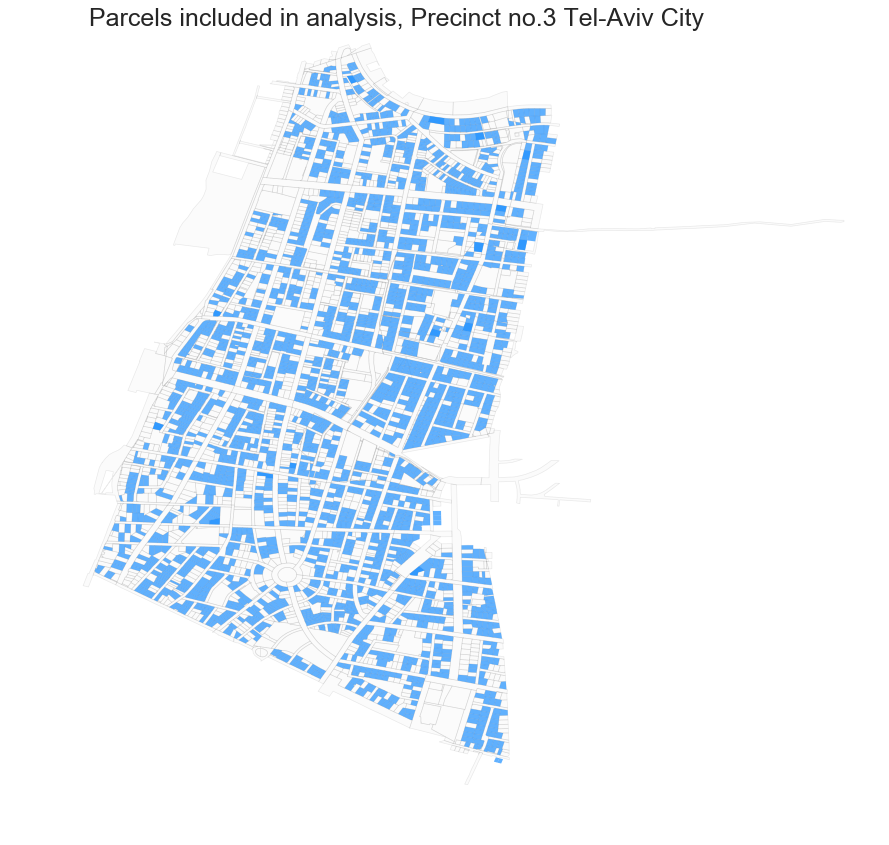

In [557]:
fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp.plot(ax=ax, color='dodgerblue', edgecolor=None, alpha=0.7);
plt.title('Parcels included in analysis, Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

### Fig.3 Parcels included in the analysis
In this analysis **2172 parcels** were included. **1310 parcels** are within the White Coty Zone and **862 parcels** are outsode of it.

-----

# FAR distribution precinct 3 -- current

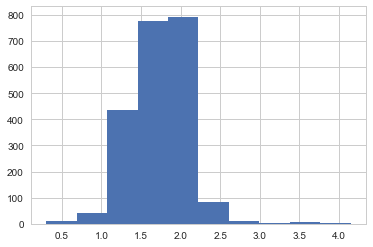

In [558]:
PCT3shp[PCT3shp['FAR'] <= 4.25]['FAR'].hist()
# plot the cumulative function
#plt.plot(, cumulative, c='blue')

# Plot a map of Floor Area for precinct 3

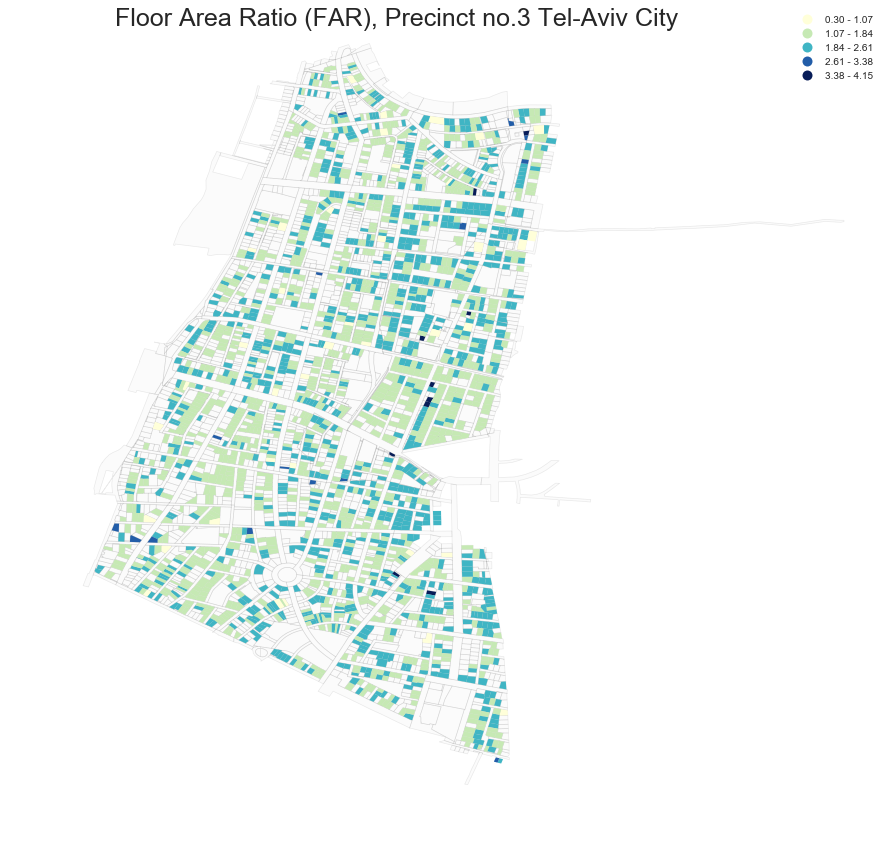

In [559]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp[PCT3shp['FAR'] <= 4.25] .plot(ax=ax, column='FAR', cmap='YlGnBu', scheme='Equal_Interval', legend=True);
plt.title('Floor Area Ratio (FAR), Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
#ax.legend()
tmp = ax.axis('off')

### Fig.4 Current Floor-Area Ratio (FAR) 
The majority of the buildings' FAR is ranged between **1.07 - 2.2**

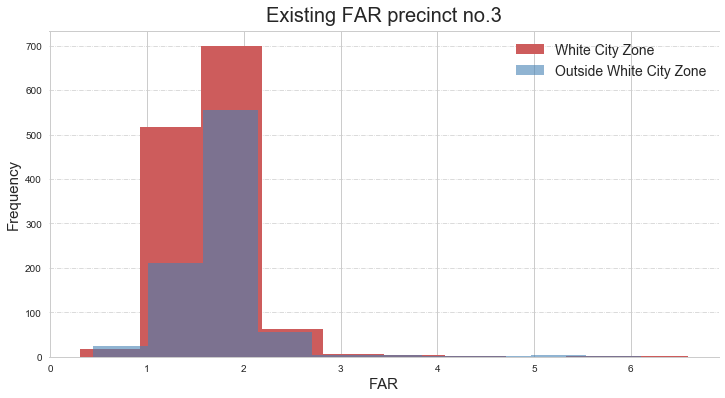

In [560]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)

(PCT3shp['FAR'][PCT3shp['WhiteCity'] == 1]).plot(kind="hist", color='IndianRed',
                                            label='White City Zone')
ax = (PCT3shp['FAR'][PCT3shp['WhiteCity'] == 0]).plot(kind="hist", color='steelBlue',
                             label='Outside White City Zone', alpha=0.6)

ax.set_title("Existing FAR precinct no.3", fontsize=20, y=1.01)
ax.set_xlabel("FAR", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(linewidth=0.7, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

---
## Defining commercial streets 
- Inside White City Zone: **Dizengof, Ben-Yehuda, Arlozorov, Hayarkon** streets
- Outside White City Zone: **Dizengof, Ben-Yehuda** streets

In [561]:
commerceIN = [PCT3shpIN[PCT3shpIN['streetName']  == 'דיזנגוף'], PCT3shpIN[PCT3shpIN['streetName']  == 'בן יהודה'], 
              PCT3shpIN[PCT3shpIN['streetName']  == 'ארלוזורוב'], PCT3shpIN[PCT3shpIN['streetName']  == 'הירקון']]
commerceIN = pd.concat(commerceIN).reset_index()
commerceIN = commerceIN.drop(['index', 'streetName'], axis=1)
commerceIN['commerce'] = 1

commerceIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce
0,306.0,"POLYGON ((34.77406439592887 32.08376795464817,...","(7078.0, 116.0)",178816.173765,665691.591844,34.773967,32.083794,3.0,134.125293,15.0,402.375878,1.314954,1,1
1,434.0,"POLYGON ((34.77371048563466 32.08158037063139,...","(7113.0, 55.0)",178775.923750,665441.716936,34.773551,32.081539,3.0,222.888763,18.0,668.666289,1.540706,1,1
2,554.0,"POLYGON ((34.77452953052502 32.08566399724136,...","(6902.0, 158.0)",178863.126875,665903.669985,34.774455,32.085708,3.0,309.996586,13.0,929.989758,1.678682,1,1


In [562]:
commerceIN.shape

(157, 14)

In [563]:
commerceOUT = [PCT3shpOUT[PCT3shpOUT['streetName']  == 'דיזנגוף'], PCT3shpOUT[PCT3shpOUT['streetName']  == 'בן יהודה']]
commerceOUT = pd.concat(commerceOUT).reset_index()
commerceOUT = commerceOUT.drop(['index', 'streetName'], axis=1)
commerceOUT['commerce'] = 1

commerceOUT.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce
0,283.0,"POLYGON ((34.77626542263859 32.0959676525227, ...","(6963.0, 9.0)",179038.103437,667047.076281,34.776261,32.096025,4.0,133.578753,20.0,534.315012,1.888039,0,1
1,458.0,"POLYGON ((34.77638620981109 32.09411838256487,...","(6961.0, 58.0)",179066.931547,666844.326250,34.776575,32.094198,3.0,220.570635,17.0,661.711904,1.444786,0,1
2,350.0,"POLYGON ((34.77709255079024 32.09395967222037,...","(6959.0, 76.0)",179094.392500,666821.373140,34.776866,32.093992,3.0,157.218641,16.0,471.655924,1.347588,0,1


In [564]:
commerceOUT.shape

(76, 14)

In [565]:
# dropping commerce from PCT3IN 

PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'דיזנגוף'])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'בן יהודה']) 
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'ארלוזורוב'])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'הירקון']).reset_index()

PCT3shpIN['commerce'] = 0

PCT3shpIN = PCT3shpIN.drop(['index', 'streetName'], axis=1)
PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,1,0
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,1,0
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,1,0


In [566]:
PCT3shpIN.shape

(1153, 14)

In [567]:
# dropping commerce from PCT3OUT

PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['streetName']  != 'דיזנגוף'])
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['streetName']  != 'בן יהודה']).reset_index()

PCT3shpOUT['commerce'] = 0

PCT3shpOUT = PCT3shpOUT.drop(['index', 'streetName'], axis=1)
PCT3shpOUT.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce
0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",179300.251875,666835.216860,34.779047,32.094123,4.0,117.242392,13.0,468.969568,1.705344,0,0
1,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",178975.822157,666836.638796,34.775610,32.094125,4.0,208.665958,18.0,834.663832,2.001592,0,0
2,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",179141.806578,666693.248156,34.777374,32.092838,4.0,155.031697,17.0,620.126790,1.908082,0,0


In [568]:
PCT3shpOUT.shape

(786, 14)

---
# Calculating new rezoning parameters: anticipated FA,  anticipated FAR, Floors

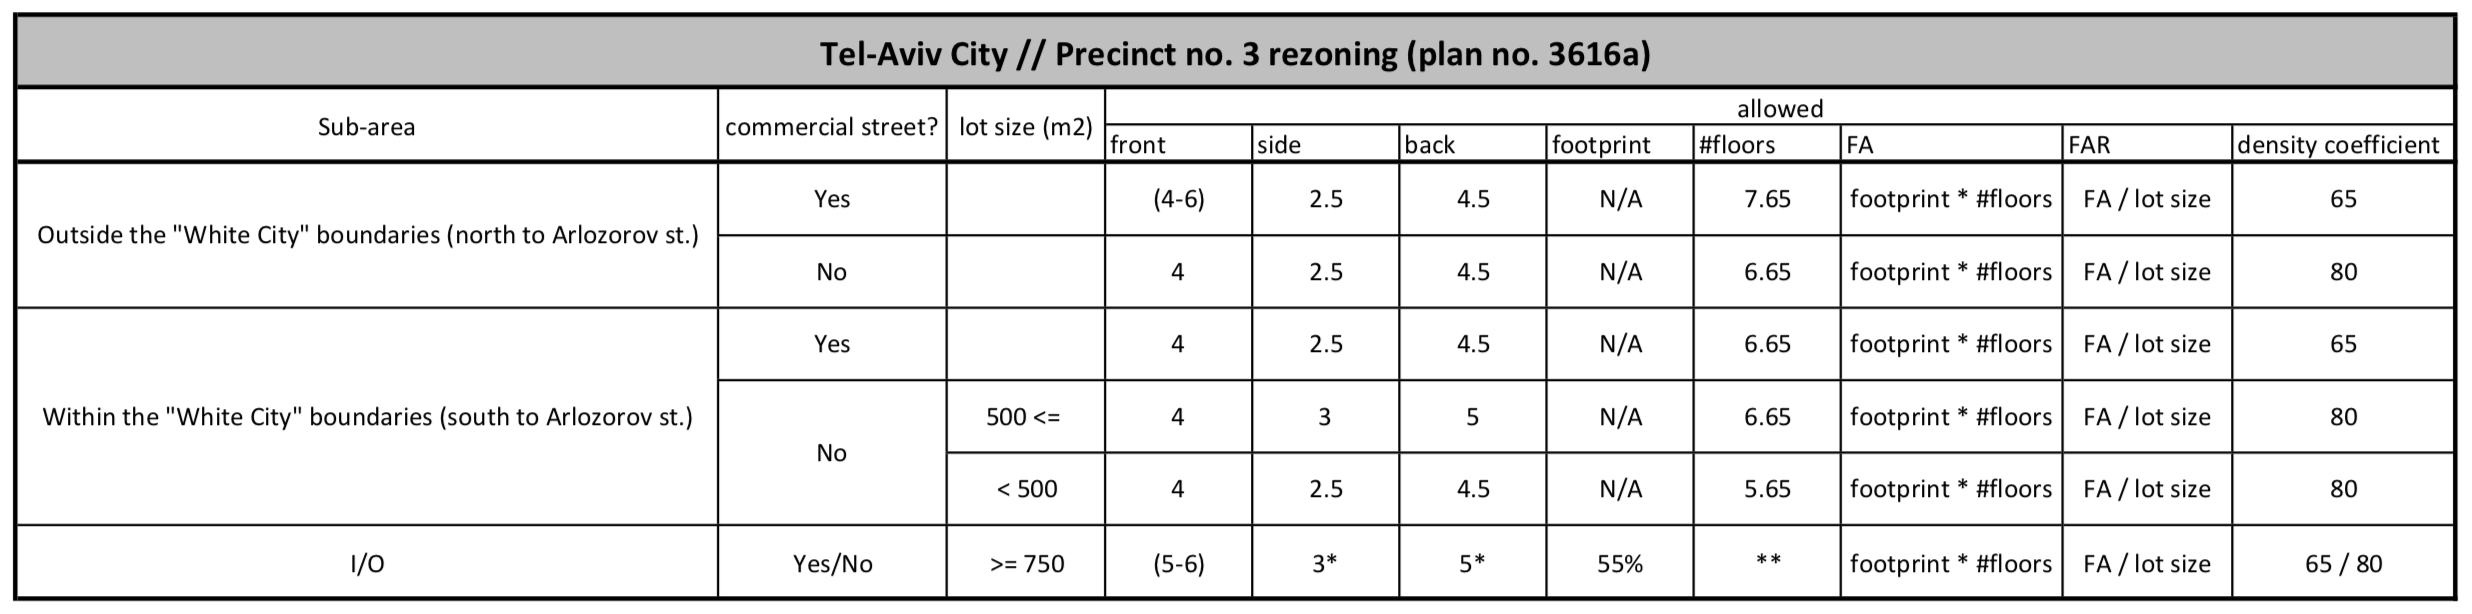

In [569]:
# Rezoning Precinct3 table

from IPython.display import Image
Image('precinct3rezoning.png')

### Table.1 Precinct no. 3 rezoning guidlines
Outside the **"White City"** zone ....
Inside the **"White City"** zone ....

In [570]:
import random
random.seed(777)

In [571]:
# creating random footprint for further calculation >> assuming footprint between 42% - 55%

PCT3shpIN['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(PCT3shpIN))
PCT3shpOUT['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(PCT3shpOUT))
commerceIN['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(commerceIN))
commerceOUT['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(commerceOUT))

PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,randFootprint
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,1,0,0.428426
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,1,0,0.434947
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,1,0,0.444411


In [572]:
# new footprint (random between 0.4 and 0.55 footprint for small parcels)
PCT3shpIN['footprint_new'] = np.where(PCT3shpIN['ParcelArea'] >= 750, PCT3shpIN['ParcelArea'] * 0.55,
                                      PCT3shpIN['ParcelArea'] * PCT3shpIN['randFootprint'])
PCT3shpOUT['footprint_new'] = np.where(PCT3shpOUT['ParcelArea'] >= 750, PCT3shpOUT['ParcelArea'] * 0.55,
                                       PCT3shpOUT['ParcelArea'] * PCT3shpOUT['randFootprint'])
commerceIN['footprint_new'] = np.where(commerceIN['ParcelArea'] >= 750, commerceIN['ParcelArea'] * 0.55, 
                                       commerceIN['ParcelArea'] * commerceIN['randFootprint'])
commerceOUT['footprint_new'] = np.where(commerceOUT['ParcelArea'] >= 750, commerceOUT['ParcelArea'] * 0.55, 
                                        commerceOUT['ParcelArea'] * commerceOUT['randFootprint'])

# new no. of floors 
PCT3shpIN['Floors_new'] = np.where(PCT3shpIN['ParcelArea'] < 500, 5.65, 6.65)
PCT3shpOUT['Floors_new'] = 6.65
commerceIN['Floors_new'] = 6.65
commerceOUT['Floors_new'] = 7.65

PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,randFootprint,footprint_new,Floors_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,1,0,0.428426,117.388852,5.65
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,1,0,0.434947,223.562769,6.65
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,1,0,0.444411,152.877462,5.65


In [573]:
commerceOUT.head(2)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,randFootprint,footprint_new,Floors_new
0,283.0,"POLYGON ((34.77626542263859 32.0959676525227, ...","(6963.0, 9.0)",179038.103437,667047.076281,34.776261,32.096025,4.0,133.578753,20.0,534.315012,1.888039,0,1,0.426964,120.830909,7.65
1,458.0,"POLYGON ((34.77638620981109 32.09411838256487,...","(6961.0, 58.0)",179066.931547,666844.326250,34.776575,32.094198,3.0,220.570635,17.0,661.711904,1.444786,0,1,0.531278,243.325507,7.65


In [574]:
# anticipated floorarea 
PCT3shpIN['FA_new'] = PCT3shpIN['footprint_new'] * PCT3shpIN['Floors_new']
PCT3shpOUT['FA_new'] = PCT3shpOUT['footprint_new'] * PCT3shpOUT['Floors_new']
commerceIN['FA_new'] = commerceIN['footprint_new'] * commerceIN['Floors_new']
commerceOUT['FA_new'] = commerceOUT['footprint_new'] * commerceOUT['Floors_new']

# anticipated FAR 
# PCT3shp['FAR_new'] = PCT3shp['FA_new'] / PCT3shp['ParcelArea']
# PCT3shp.head(3)

In [575]:
# Ratio current / anticipated floorarea 
PCT3shpIN['old/new_FA'] = PCT3shpIN['FloorArea'] / PCT3shpIN['FA_new']
PCT3shpOUT['old/new_FA'] = PCT3shpOUT['FloorArea'] / PCT3shpOUT['FA_new']
commerceIN['old/new_FA'] = commerceIN['FloorArea'] / commerceIN['FA_new']
commerceOUT['old/new_FA'] = commerceOUT['FloorArea'] / commerceOUT['FA_new']

PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,randFootprint,footprint_new,Floors_new,FA_new,old/new_FA
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,1,0,0.428426,117.388852,5.65,663.247015,0.698463
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,1,0,0.434947,223.562769,6.65,1486.692417,0.679443
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,1,0,0.444411,152.877462,5.65,863.757660,0.794494


## Concat all df 

In [576]:
PCT3all = [PCT3shpIN, PCT3shpOUT, commerceIN, commerceOUT]
PCT3shp = pd.concat(PCT3all)
PCT3shp = PCT3shp.drop(['AddressX', 'AddressY', 'lon', 'lat', 'randFootprint'], axis=1)
PCT3shp.head()

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,footprint_new,Floors_new,FA_new,old/new_FA
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,1,0,117.388852,5.65,663.247015,0.698463
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,1,0,223.562769,6.65,1486.692417,0.679443
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,1,0,152.877462,5.65,863.757660,0.794494
3,360.0,"POLYGON ((34.77120676544948 32.07850701386839,...","(6906.0, 81.0)",4.0,150.359237,19.0,601.436948,1.670658,1,0,193.424644,5.65,1092.849236,0.550338
4,339.0,"POLYGON ((34.77061162187506 32.07857072714503,...","(6906.0, 92.0)",3.0,168.250159,16.0,504.750477,1.488939,1,0,155.639237,5.65,879.361689,0.573996


In [577]:
PCT3shp.shape

(2172, 14)

In [578]:
# anticipated floorarea 
PCT3shp['FA_new'] = PCT3shp['footprint_new'] * PCT3shp['Floors_new']

# anticipated FAR 
PCT3shp['FAR_new'] = PCT3shp['FA_new'] / PCT3shp['ParcelArea']
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,footprint_new,Floors_new,FA_new,old/new_FA,FAR_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,1,0,117.388852,5.65,663.247015,0.698463,2.420610
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,1,0,223.562769,6.65,1486.692417,0.679443,2.892398
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,1,0,152.877462,5.65,863.757660,0.794494,2.510923


# FAR distribution precinct 3 -- all rezoning utilized

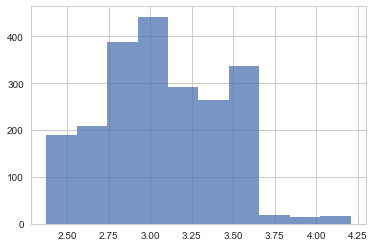

In [579]:
#PCT3shp['FAR'].hist(alpha=0.75)
PCT3shp['FAR_new'].hist(alpha=0.75)

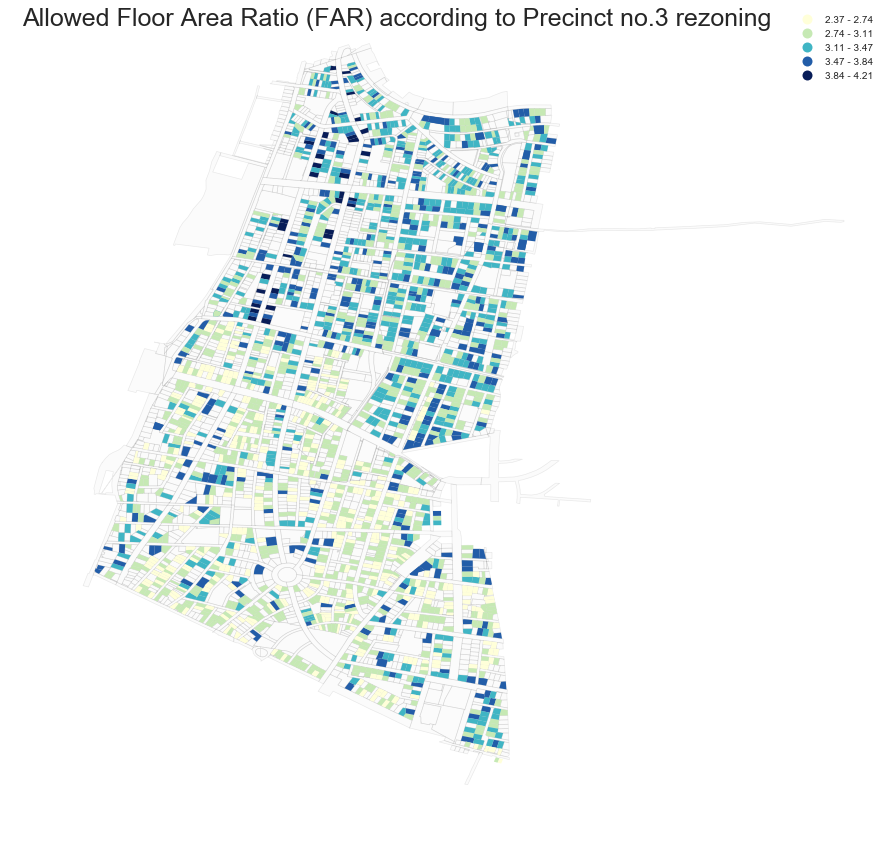

In [580]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp.plot(ax=ax, column='FAR_new', cmap='YlGnBu', scheme='Equal_Interval', legend=True);
plt.title('Allowed Floor Area Ratio (FAR) according to Precinct no.3 rezoning', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

### Fig.5 Anticipated Floor-Area Ratio (FAR), if all Precinct no.3 rezoning utilized
The northern part of the precinct (outside the White City boundaries) has distinguishable higher FAR, although being far from the CBD (The centroid of Precinct no.5, south to Precinct no.3)

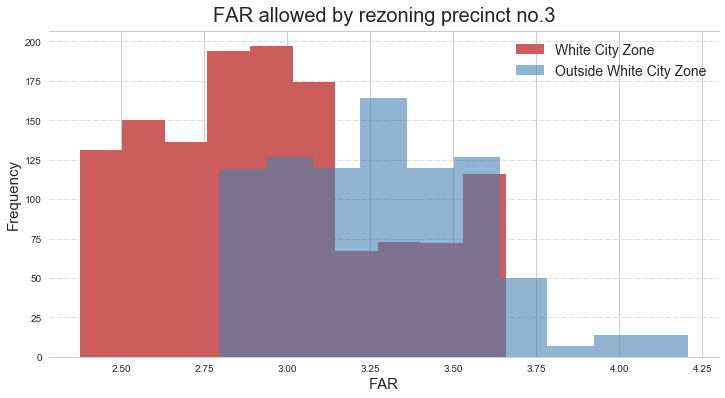

In [581]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)

(PCT3shp['FAR_new'][PCT3shp['WhiteCity'] == 1]).plot(kind="hist", color='IndianRed',
                                            label='White City Zone')
ax = (PCT3shp['FAR_new'][PCT3shp['WhiteCity'] == 0]).plot(kind="hist", color='steelBlue',
                             label='Outside White City Zone', alpha=0.6)

ax.set_title("FAR allowed by rezoning precinct no.3", fontsize=20, y=1.01)
ax.set_xlabel("FAR", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(linewidth=0.7, axis='y', linestyle='-.')

plt.legend(fontsize=14)
plt.show()

In [582]:
PCT3shp.shape[1]

15

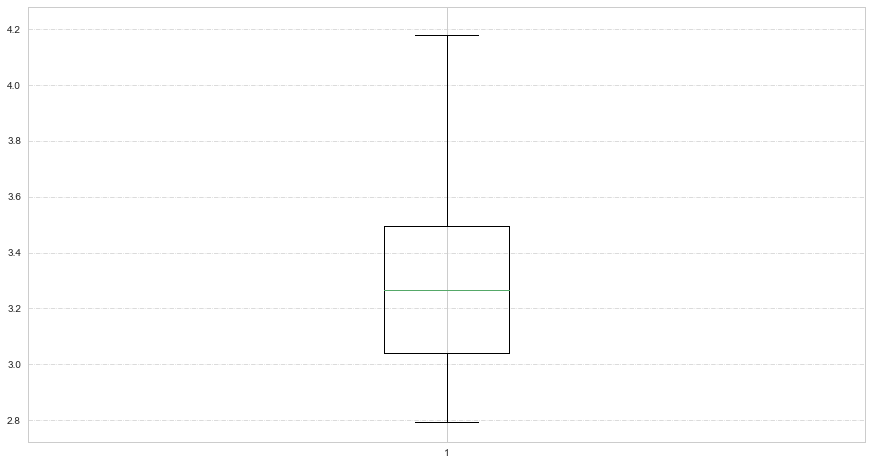

In [588]:
plt.figure(figsize = (15, 8))

for i in range(PCT3shp.shape[1]):
    plt.boxplot(PCT3shp['FAR_new'][PCT3shp['WhiteCity'] == 0])
#plt.boxplot(PCT3shp['FAR_new'][PCT3shp['WhiteCity'] == 0])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(linewidth=0.7, axis='y', linestyle='-.')

ax.set_xlabel("FAR allowed by rezoning precinct no.3", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)

plt.show()

## ratio of current / allowed floor area

In [620]:
# Ratio current / anticipated floorarea 
PCT3shp['old/new_FA'] = PCT3shp['FloorArea'] / PCT3shp['FA_new'] 
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,footprint_new,Floors_new,FA_new,old/new_FA,FAR_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,1,0,117.388852,5.65,663.247015,0.698463,2.420610
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,1,0,223.562769,6.65,1486.692417,0.679443,2.892398
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,1,0,152.877462,5.65,863.757660,0.794494,2.510923


In [621]:
feasThreshold = [
    (PCT3shp['ParcelArea'] < 350) & (PCT3shp['old/new_FA'] <= 0.45),
    (PCT3shp['ParcelArea'] >= 750) & (PCT3shp['old/new_FA'] <= 0.55),
    (PCT3shp['ParcelArea'] >= 350) & (PCT3shp['ParcelArea'] < 750) & (PCT3shp['old/new_FA'] <= 0.5)]
choices = [1, 1, 1]
PCT3shp['Feasibility'] = np.select(feasThreshold, choices, default=0)
PCT3shp['Feasibility'].value_counts()

0    1615
1     557
Name: Feasibility, dtype: int64

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


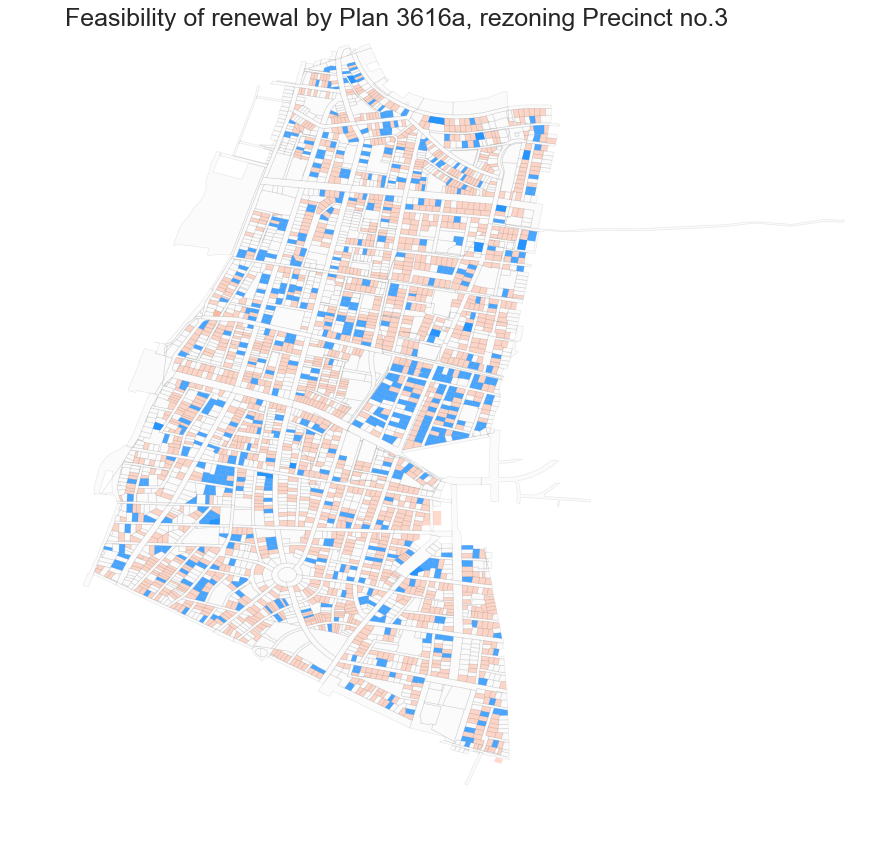

In [622]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp[PCT3shp['Feasibility'] == 1].plot(ax=ax, color='dodgerblue', edgecolor=None, label='Feasible',alpha=0.8)
PCT3shp[PCT3shp['Feasibility'] == 0].plot(ax=ax, color='orangered', edgecolor=None, label='Not Feasible', alpha=0.2)
plt.title('Feasibility of renewal by Plan 3616a, rezoning Precinct no.3', size=25, y=.97, x=0.42)
ax.legend(fontsize=14)
tmp = ax.axis('off')

### Fig.6 Feasibility by parcel, rezoning Precinct no.3
Red parcels are **Not feasible** and will not be renewed, while the green parcels are **feasible** and are anticipated to be renewed according to the new rezoning of the precinct.

In [623]:
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,footprint_new,Floors_new,FA_new,old/new_FA,FAR_new,Feasibility
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,1,0,117.388852,5.65,663.247015,0.698463,2.420610,0
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,1,0,223.562769,6.65,1486.692417,0.679443,2.892398,0
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,1,0,152.877462,5.65,863.757660,0.794494,2.510923,0


---
# Predicting future FAR according to parcels' renewal feasibility
Parcels that were calculated to be **feasible** for renewal >> **_New FAR_**<br/>
Parcels that were calculated to be **not-feasible** for renewal >>** _current FAR_**

In [624]:
PCT3shp['predictedFAR'] = np.where(PCT3shp['Feasibility'] == 1, PCT3shp['FAR_new'], PCT3shp['FAR'])
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,WhiteCity,commerce,footprint_new,Floors_new,FA_new,old/new_FA,FAR_new,Feasibility,predictedFAR
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,1,0,117.388852,5.65,663.247015,0.698463,2.420610,0,1.690705
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,1,0,223.562769,6.65,1486.692417,0.679443,2.892398,0,1.965220
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,1,0,152.877462,5.65,863.757660,0.794494,2.510923,0,1.994913


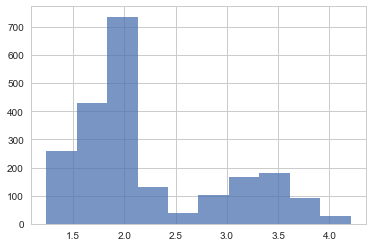

In [625]:
PCT3shp[PCT3shp['predictedFAR'] <= 4.25]['predictedFAR'].hist(alpha=0.75)

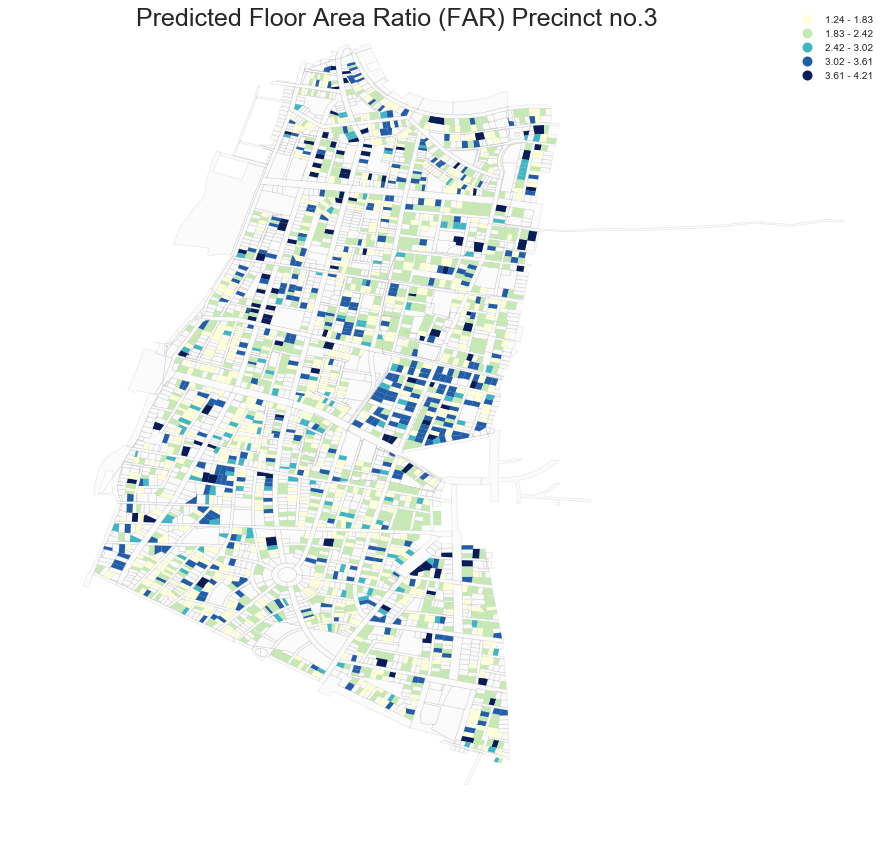

In [626]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.7, alpha=0.08)
PCT3shp[PCT3shp['predictedFAR'] < 4.25].plot(ax=ax, column='predictedFAR', cmap='YlGnBu', scheme='Equal_Interval', legend=True);
plt.title('Predicted Floor Area Ratio (FAR) Precinct no.3', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

In [410]:
PCT3shp.columns

Index(['ParcelArea', 'geometry', 'BBL', 'Floors', 'footprint', 'height',
       'FloorArea', 'FAR', 'WhiteCity', 'commerce', 'footprint_new',
       'Floors_new', 'FA_new', 'old/new_FA', 'FAR_new', 'Feasibility',
       'predictedFAR'],
      dtype='object')

In [411]:
PCT3short = PCT3shp.drop(['geometry', 'BBL', 'height'], axis=1)
PCT3short.head(3)

,ParcelArea,Floors,footprint,FloorArea,FAR,WhiteCity,commerce,footprint_new,Floors_new,FA_new,old/new_FA,FAR_new,Feasibility,predictedFAR
0,274.0,3.0,154.417758,463.253274,1.690705,1,0,119.834851,5.65,677.066911,0.684206,2.471047,0,1.690705
1,514.0,4.0,252.530801,1010.123204,1.965220,1,0,244.157239,6.65,1623.645638,0.622133,3.158844,0,1.965220
2,344.0,4.0,171.562549,686.250196,1.994913,1,0,149.587751,5.65,845.170795,0.811966,2.456892,0,1.994913


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


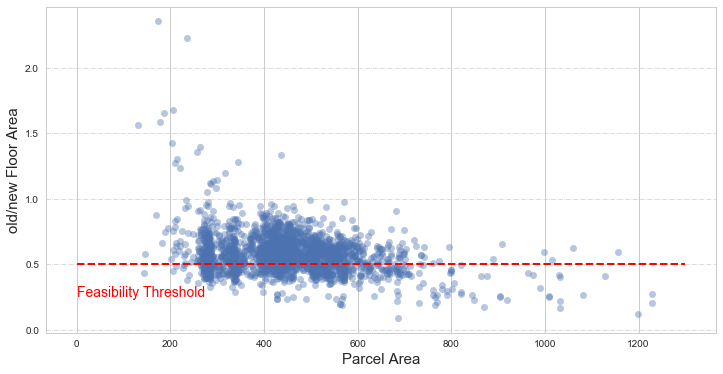

In [619]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)

pl.plot(PCT3short['ParcelArea'], PCT3short['old/new_FA'], 'o', alpha=0.4)

#ax.set_title("FAR allowed by rezoning precinct no.3", fontsize=20, y=1.01)
ax.set_xlabel("Parcel Area", fontsize=15)
ax.set_ylabel("old/new Floor Area", fontsize=15)
plt.plot((0, 1300),(0.5,0.5), 'r--', linewidth=2)
plt.annotate('Feasibility Threshold', xy=(0.8, 0.6), xytext=(0, .25),
            arrowprops=dict(facecolor='black', headwidth=0, 
                headlength=0, color='r'),color='r', fontsize=14)

#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.grid(linewidth=0.7, axis='y', linestyle='-.')

#plt.legend(fontsize=14)
plt.show()

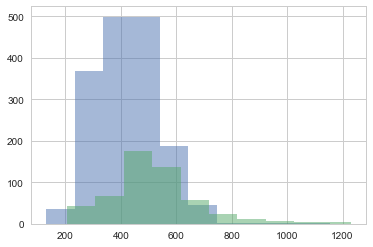

In [250]:
PCT3short['ParcelArea'][PCT3short['Feasibility'] == 0].hist(alpha=0.5)
PCT3short['ParcelArea'][PCT3short['Feasibility'] == 1].hist(alpha=0.5)

# white city; commerce!

## Future research:
- Linear regression: White city yes/no >> Feasibility
- Multilinear regression and/or ML(DT): White city yes/no, parcelarea, commercial >> Feasibility